In [1]:
import pandas as pd
from tqdm import tqdm
from pyarrow import csv
import pyarrow as pa

import numpy as np

import pandas as pd
from tqdm import tqdm
from pyarrow import csv
import pyarrow as pa

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from catboost import CatBoostClassifier
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler, StandardScaler
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, roc_curve, precision_recall_curve

In [2]:
def default_transform(df):
    return df

def read_chunk(name, chunk_id, opts=csv.ConvertOptions(), transform=default_transform, extra=1):
    chunk=None
    chunksize = extra*10 ** 7
    with csv.open_csv(
        name,
        convert_options = opts,
        read_options=csv.ReadOptions(
            use_threads=True,
            block_size=chunksize
        )) as reader:

        i=0
        for next_chunk in reader:
            if next_chunk is None:
                break
            chunk=next_chunk
            if i == chunk_id:
                return transform(chunk.to_pandas())
            i+=1
            
    return None

def prep_NF_UQ(df):
    cols =[   'PROTOCOL', 
              'IN_PKTS', 
              'OUT_PKTS',
              'IN_BYTES',
              'OUT_BYTES',
              'DURATION_IN',
              'DURATION_OUT',
              'Label' 
             ]
    return df[cols]

def prep_ddos(df):
    chose_cols_s=[
        ' Protocol', 
        ' Total Fwd Packets', 
        ' Total Backward Packets',
        'Total Length of Fwd Packets',
        ' Total Length of Bwd Packets',
        'Fwd IAT Total',
        'Bwd IAT Total',
        ' Label' 
        ]
    
    df = df[['PROTOCOL', 'IN_PKTS', 'OUT_PKTS', 'IN_BYTES', 'OUT_BYTES', 'DURATION_IN', 'DURATION_OUT', 'Label']]
    
    df['PROTOCOL'] = df['PROTOCOL'].astype(np.int64)
    df['IN_PKTS'] = df['IN_PKTS'].astype(np.int64)
    df['OUT_PKTS'] = df['OUT_PKTS'].astype(np.int64)
    df['IN_BYTES'] = df['IN_BYTES'].astype(np.int64)
    df['OUT_BYTES'] = df['OUT_BYTES'].astype(np.int64)
    df['DURATION_IN']= (df['DURATION_IN']/1000000).astype(np.int64)
    df['DURATION_OUT']= (df['DURATION_OUT']/1000000).astype(np.int64)
    df = df.drop(['Label'],axis=1)
    df['Label'] = 1
    return df

In [3]:
df = pd.read_csv('cic-ddos2019.csv')

/tmp/ipykernel_150071/3402670326.py:1: DtypeWarning: Columns (109) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cic-ddos2019.csv')


In [4]:
ddos_df = prep_ddos(df)

/tmp/ipykernel_150071/2477638505.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PROTOCOL'] = df['PROTOCOL'].astype(np.int64)
/tmp/ipykernel_150071/2477638505.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IN_PKTS'] = df['IN_PKTS'].astype(np.int64)
/tmp/ipykernel_150071/2477638505.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [39]:
df = pd.read_parquet('NF-UNSW-NB15-V2.parquet')

In [6]:
df = prep_NF_UQ(df)

In [7]:
df

,PROTOCOL,IN_PKTS,OUT_PKTS,IN_BYTES,OUT_BYTES,DURATION_IN,DURATION_OUT,Label
0,0,60959,462,0,0,119,114,1
1,17,2,0,2944,0,0,0,1
2,17,2,0,2944,0,0,0,1
3,17,2,0,2944,0,0,0,1
4,17,2,0,2848,0,0,0,1
...,...,...,...,...,...,...,...,...
408523,17,2,2,62,94,0,0,1
408524,17,2,2,62,94,0,0,1
408525,17,2,2,50,82,0,0,1
408526,17,2,2,62,164,0,0,1


In [41]:
Y_nf = df.Label
Y_dd = ddos_df.Label

Y = np.concatenate((Y_nf, Y_dd))

NameError: name 'ddos_df' is not defined

In [25]:
ddos_df.drop(columns=['Label'], axis=1, inplace=True) 
df.drop(columns=['Label'], axis=1, inplace=True) 

In [27]:
df = np.concatenate((df, ddos_df))

In [29]:
df.shape

(2395273, 7)

In [31]:
del ddos_df

In [32]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

X_train, X_test, y_train, y_test = train_test_split(df, Y, test_size=0.3, random_state=42)

In [33]:
clf = CatBoostClassifier(iterations=10)
clf.fit(X_train, y_train, verbose = False, early_stopping_rounds=100) 

In [34]:
accuracy_score(y_test, clf.predict(X_test))

0.9866111313670535

In [36]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(X_test)).ravel()

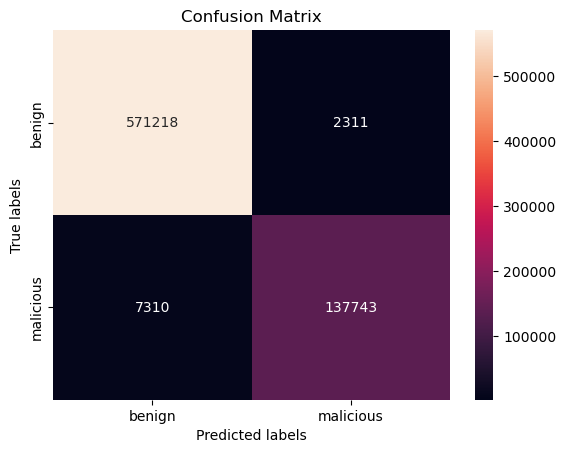

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap([[tn, fp],[fn, tp]], annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['benign', 'malicious']); ax.yaxis.set_ticklabels(['benign', 'malicious']);

In [10]:
def visualize(data):
    label = data['Label']
    data = data.drop(['Label'], axis=1)
    
    x = data.to_numpy()
    scaler = MinMaxScaler().fit(x) 
    x = scaler.transform(x)
    y = label.to_numpy()
    
    tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=400).fit_transform(x)
    
    plot_2d(tsne[:, 0],tsne[:, 1], y)
    
    X_LDA = LDA(n_components=1).fit_transform(x,y)
    

    plt.style.use('_mpl-gallery')
    fig, ax = plt.subplots()
    ax.scatter(X_LDA, y=X_LDA, c=list(map(to_color, y)), vmin=0, vmax=100)

In [11]:
visualize(df)

/home/nexei/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nexei/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: 

In [8]:
df

,PROTOCOL,IN_PKTS,OUT_PKTS,IN_BYTES,OUT_BYTES,DURATION_IN,DURATION_OUT,Label
0,0,60959,462,0,0,119,114,1
1,17,2,0,2944,0,0,0,1
2,17,2,0,2944,0,0,0,1
3,17,2,0,2944,0,0,0,1
4,17,2,0,2848,0,0,0,1
...,...,...,...,...,...,...,...,...
408523,17,2,2,62,94,0,0,1
408524,17,2,2,62,94,0,0,1
408525,17,2,2,50,82,0,0,1
408526,17,2,2,62,164,0,0,1
